In [ ]:
!pip install node2vec

import networkx as nx
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import requests
import gzip
import shutil
from networkx.algorithms.community import modularity

# --- CONFIGURATION ---
P_RETURN = 2
Q_IN_OUT = 1
DIMENSIONS = 64
WALK_LENGTH = 30
NUM_WALKS = 10
NUM_CLUSTERS = 10  # k=10 for k-means

DATASET_URL = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
DATASET_PATH = 'facebook_combined.txt'

In [2]:
def download_dataset():
    if os.path.exists(DATASET_PATH):
        return

    response = requests.get(DATASET_URL, stream=True)

    if response.status_code == 200:
        compressed_file = "twitter_combined.txt.gz"
        with open(compressed_file, 'wb') as f:
            f.write(response.content)

        with gzip.open(compressed_file, 'rb') as f_in:
            with open(DATASET_PATH, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

        os.remove(compressed_file)
        print("Download complete")
    else:
        print(f"failed to download, {response.status_code}")
        raise Exception("Download failed")

download_dataset()

Download complete


In [3]:
def load_graph(filepath):
    G = nx.read_edgelist(filepath, create_using=nx.Graph(), nodetype=int)
    print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

graph = load_graph(DATASET_PATH)

Graph loaded: 4039 nodes, 88234 edges


In [4]:
def train_model(G):
    """
    Trains the Node2Vec model using the established hyperparameters.
    """

    # use disk storage to prevent ram crash
    temp_dir = "./node2vec_temp"
    os.makedirs(temp_dir, exist_ok=True)

    start_time = time.time()

    node2vec = Node2Vec(
        G,
        dimensions=DIMENSIONS,
        walk_length=WALK_LENGTH,
        num_walks=NUM_WALKS,
        p=P_RETURN,
        q=Q_IN_OUT,
        workers=4,
        temp_folder=temp_dir,
        quiet=False
    )

    print(f"Pre-computation took {time.time() - start_time:.2f} seconds")

    print("Training model on random walks...")
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    return model

model = train_model(graph)

Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/3 [00:00<?, ?it/s]


Generating walks (CPU: 4):   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 2):  67%|██████▋   | 2/3 [00:11<00:05,  5.71s/it]


Generating walks (CPU: 4): 100%|██████████| 2/2 [00:11<00:00,  5.80s/it]

Generating walks (CPU: 3): 100%|██████████| 2/2 [00:21<00:00, 10.95s/it]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:25<00:00,  8.57s/it]


Pre-computation took 101.78 seconds
Training model on random walks...


In [5]:
filename = "twitter_embeddings_d64_p2_q1.emb"
model.wv.save_word2vec_format(filename)
print(f"Embeddings saved as {filename}")


Embeddings saved as twitter_embeddings_d64_p2_q1.emb


In [6]:
def cluster_embeddings(model):
    nodes = list(model.wv.index_to_key)
    vectors = [model.wv[node] for node in nodes]

    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
    kmeans.fit(vectors)
    labels = kmeans.labels_

    return dict(zip(nodes, labels))

communities = cluster_embeddings(model)
print("Clustering complete:", list(communities.items())[:5])

Clustering complete: [('3437', 0), ('107', 9), ('1684', 3), ('0', 4), ('1912', 7)]


In [7]:
def calculate_metrics(G, communities_dict, top_n=10, k=100):


    community_sets = {}

    first_graph_node = next(iter(G.nodes()))
    convert_to_int = isinstance(first_graph_node, int)
    # 1. modularity calculation
    for node_id, label in communities_dict.items():
        try:
            node = int(node_id) if convert_to_int else node_id
        except ValueError:
            continue
        if node in G:
            if label not in community_sets:
                community_sets[label] = set()
            community_sets[label].add(node)

    valid_nodes = set().union(*community_sets.values())
    G_sub = G.subgraph(valid_nodes)

    if len(G_sub) > 0:
        mod_score = modularity(G_sub, list(community_sets.values()))
        print(f"Modularity Score: {mod_score:.4f}")
    else:
        print("Modularity Score Error")

    # 2. betweenness centrality calculation

    centrality = nx.betweenness_centrality(G, k=k, normalized=True, seed=42)

    top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]

    print(f"Top {top_n} Influencers:")
    print(f"{'Rank':<5} | {'Node ID':<15} | {'Score'}")
    print("-" * 40)
    for i, (node, score) in enumerate(top_nodes, 1):
        print(f"{i:<5} | {str(node):<15} | {score:.6f}")

calculate_metrics(graph, communities, k=100)

Modularity Score: 0.8264
Top 10 Influencers:
Rank  | Node ID         | Score
----------------------------------------
1     | 107             | 0.497134
2     | 1684            | 0.345842
3     | 1912            | 0.235930
4     | 3437            | 0.187493
5     | 0               | 0.157313
6     | 1085            | 0.131142
7     | 698             | 0.092612
8     | 58              | 0.091865
9     | 567             | 0.075884
10    | 428             | 0.061589


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


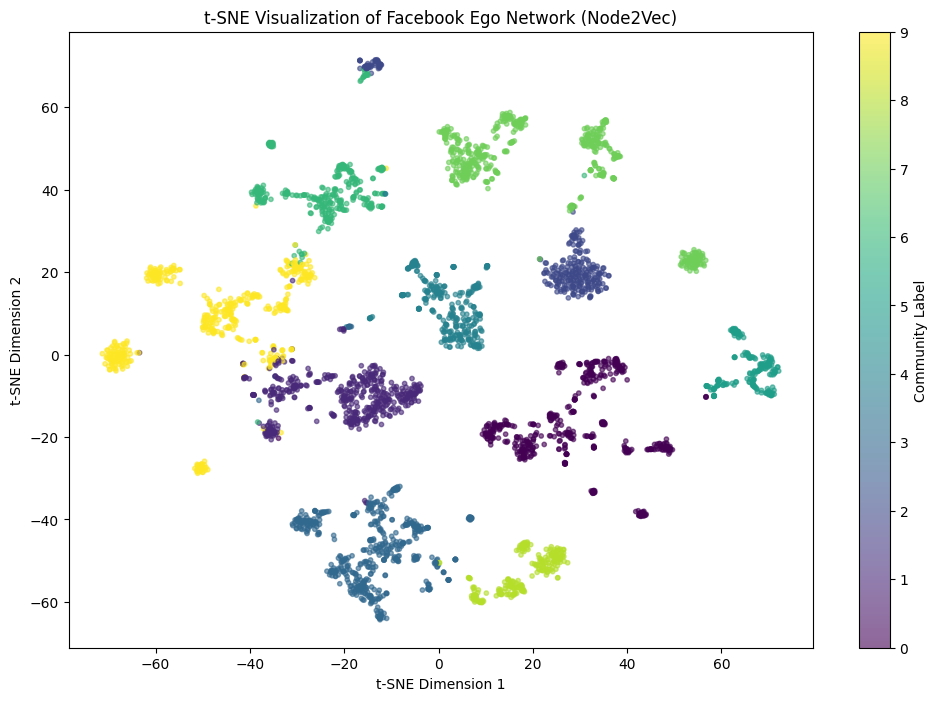

In [8]:
def visualize_embeddings(model, communities, num_nodes_to_plot=10000):
    all_nodes = list(model.wv.index_to_key)
    if len(all_nodes) > num_nodes_to_plot:
        sampled_nodes = np.random.choice(all_nodes, num_nodes_to_plot, replace=False)
    else:
        sampled_nodes = all_nodes

    vectors = np.array([model.wv[node] for node in sampled_nodes])
    labels = [communities[node] for node in sampled_nodes]

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embeddings_2d = tsne.fit_transform(vectors)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        embeddings_2d[:, 0],
        embeddings_2d[:, 1],
        c=labels,
        cmap='viridis',
        alpha=0.6,
        s=10
    )
    plt.colorbar(scatter, label='Community Label')
    plt.title("t-SNE Visualization of Facebook Ego Network (Node2Vec)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

visualize_embeddings(model, communities)